In [7]:
# Importations

import os
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from depth_anything_v2.dpt import DepthAnythingV2

xFormers not available
xFormers not available


In [8]:
# Création du dataset

# Dataset personnalisé
class DepthDataset(Dataset):
    def __init__(self, image_dir, image_files, point_cloud_dir, point_cloud_files):
        self.image_dir = image_dir
        self.image_files = image_files
        self.point_cloud_dir = point_cloud_dir
        self.point_cloud_files = point_cloud_files
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        xyz_path = os.path.join(self.point_cloud_dir, self.point_cloud_files[idx])
        
        image = Image.open(image_path).convert("RGB")
        xyz = np.load(xyz_path)
        
        return image, torch.tensor(xyz, dtype=torch.float32)

In [9]:
# Test d'affichage d'une image

image = DepthDataset("dataset/images", sorted(os.listdir("dataset/images")), "dataset/depth", sorted(os.listdir("dataset/depth")))

image_, depth_ = image[50]

In [10]:
def affichage_image_depth(image, depth):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(image)
    axes[0].axis('off')
    axes[0].set_title("Image")

    axes[1].imshow(depth, cmap="viridis")
    axes[1].axis('off')
    axes[1].set_title("Nuage de points")

    plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-540.53..2400.0222].


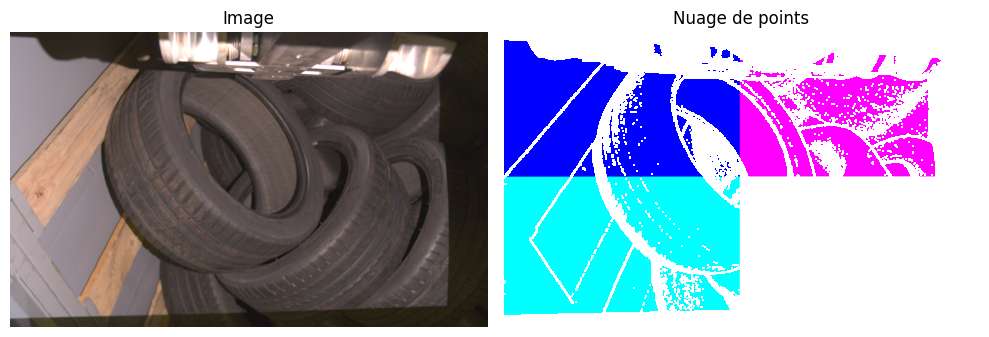

In [11]:
affichage_image_depth(image_, depth_)

In [12]:
# Chargement des données

# Paramètres
IMAGES_DIR = "dataset/images"
DEPTH_DIR = "dataset/depth"
TRAIN_RATIO = 0.8

# Liste des fichiers
images_files = sorted(os.listdir(IMAGES_DIR))
depth_files = sorted(os.listdir(DEPTH_DIR))

# Vérification de correspondance
assert len(images_files) == len(depth_files), "Les dossiers images et depth doivent contenir le même nombre de fichiers."
assert all(img.split('.')[0][:-6] == depth.split('.')[0][:-9] for img, depth in zip(images_files, depth_files)), \
    "Les noms des fichiers images et depth doivent correspondre."

# Division des données
train_indices, val_indices = train_test_split(range(len(images_files)), train_size=TRAIN_RATIO, random_state=42)

# Création des listes d'entraînement et de validation
train_images = [images_files[idx] for idx in train_indices]
val_images = [images_files[idx] for idx in val_indices]
train_depth = [depth_files[idx] for idx in train_indices]
val_depth = [depth_files[idx] for idx in val_indices]

# Créations des datasets
train_dataset = DepthDataset(IMAGES_DIR, train_images, DEPTH_DIR, train_depth)
val_dataset = DepthDataset(IMAGES_DIR, val_images, DEPTH_DIR, val_depth)

# Division en mini-lots
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [ ]:
image_train, depth_train = train_dataset[10]
affichage_image_depth(image_train, depth_train)

image_val, depth_val = val_dataset[10]
affichage_image_depth(image_val, depth_val)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-540.53..2400.0222].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-450.24265..1946.8531].


In [31]:
# Chargement du modèle Depth Anything

model = DepthAnythingV2()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for param in model.parameters():
    param.requires_grad = False

In [33]:
print(model)

DepthAnythingV2(
  (pretrained): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-23): 24 x NestedTensorBlock(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (drop): Dropout(p=0.0, inplace=Fal

In [36]:
# Création de la couche LoRA

class LoRA(nn.Module):
    def __init__(self, original_layer, r=8, alpha=32):
        super().__init__()
        self.original_layer = original_layer
        self.r = r
        self.alpha = alpha

        # Matrices de faible rang
        self.lora_A = nn.Parameter(torch.randn(original_layer.weight.size(0), r) * 0.01)
        self.lora_B = nn.Parameter(torch.randn(r, original_layer.weight.size(1)) * 0.01)
        self.scaling = alpha / r

    def forward(self, x):
        # Ajout de l'adaptation LoRA
        lora_weight = self.lora_A @ self.lora_B
        adapted_weight = self.original_layer.weight + self.scaling * lora_weight
        return nn.functional.linear(x, adapted_weight, self.original_layer.bias)


In [37]:
# Remplacement des couches

def apply_lora_to_model(model, target_modules, r=8, alpha=32):
    for name, module in model.named_modules():
        if any(target in name for target in target_modules):
            setattr(model, name, LoRA(module, r, alpha))
    return model

# Cibles à remplacer (ajustez en fonction du modèle)
target_modules = ["linear", "conv"]
model = apply_lora_to_model(model, target_modules)


AttributeError: 'Sequential' object has no attribute 'weight'

In [38]:
# Geler les paramètres

for param in model.parameters():
    param.requires_grad = False

# Seules les matrices LoRA seront entraînables
for name, param in model.named_parameters():
    if "lora" in name:
        param.requires_grad = True


In [39]:
for name, param in model.named_parameters():
    print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")


pretrained.cls_token: Frozen
pretrained.pos_embed: Frozen
pretrained.mask_token: Frozen
pretrained.patch_embed.proj.weight: Frozen
pretrained.patch_embed.proj.bias: Frozen
pretrained.blocks.0.norm1.weight: Frozen
pretrained.blocks.0.norm1.bias: Frozen
pretrained.blocks.0.attn.qkv.weight: Frozen
pretrained.blocks.0.attn.qkv.bias: Frozen
pretrained.blocks.0.attn.proj.weight: Frozen
pretrained.blocks.0.attn.proj.bias: Frozen
pretrained.blocks.0.ls1.gamma: Frozen
pretrained.blocks.0.norm2.weight: Frozen
pretrained.blocks.0.norm2.bias: Frozen
pretrained.blocks.0.mlp.fc1.weight: Frozen
pretrained.blocks.0.mlp.fc1.bias: Frozen
pretrained.blocks.0.mlp.fc2.weight: Frozen
pretrained.blocks.0.mlp.fc2.bias: Frozen
pretrained.blocks.0.ls2.gamma: Frozen
pretrained.blocks.1.norm1.weight: Frozen
pretrained.blocks.1.norm1.bias: Frozen
pretrained.blocks.1.attn.qkv.weight: Frozen
pretrained.blocks.1.attn.qkv.bias: Frozen
pretrained.blocks.1.attn.proj.weight: Frozen
pretrained.blocks.1.attn.proj.bias: Fro

In [40]:
# Entrainement avec LoRA

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

for epoch in range(num_epochs):
    for batch in data_loader:
        inputs, targets = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()


NameError: name 'num_epochs' is not defined